In [7]:
import pickle
import numpy as np
import scipy 
import torch
import matplotlib.pyplot as plt

In [8]:
with open('../experiments/FNN-DD_IC-3000-B128-lr0.001-KCondLoss/val_pred.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())

DD_mat = torch.load('../data/DD_mat_IC_L.pt')
print(DD_mat.keys())
print(data['train_inputs'][0].shape)
print(data['train_true'][0].shape)

dict_keys(['inputs', 'pred', 'train_inputs', 'train_pred', 'true', 'train_true'])
dict_keys(['A', 'L_IC'])
torch.Size([128, 1792])
torch.Size([128, 960])


In [9]:
# visualize
# put the entries back to the matrix
idx = 20
DD = DD_mat['A'][idx]
IC = DD_mat['L_IC'][idx]
mask = torch.abs(DD) != 0
mask_ic = torch.abs(IC) != 0
masks = {'DD': mask, 'L': mask_ic}
#torch.save(masks, '../data/DD_L_sparse_masks.pt')

true_ic = np.zeros_like(DD)
pred_ic = np.zeros_like(DD)

true_ic[mask_ic] = data['train_true'][0][idx]
pred_ic[mask_ic] = data['train_pred'][0][idx]

true_ic_abs = np.abs(true_ic)
pred_ic_abs = np.abs(pred_ic)

DD_val = np.zeros_like(DD)

DD_val[mask] = data['train_inputs'][0][idx]
DD_val_abs = np.abs(DD_val)
print(DD_val.shape)

(128, 128)


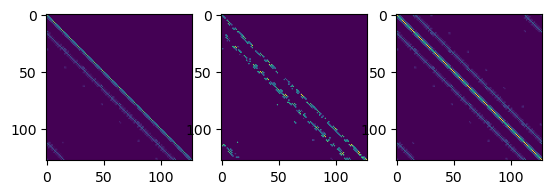

In [10]:
# visualize
vmin = np.min([true_ic_abs.min(), pred_ic_abs.min()])
vmax = np.max([true_ic_abs.max(), pred_ic_abs.max()])
fig, ax = plt.subplots(1,3)
ax[0].imshow(true_ic_abs, vmin=vmin, vmax=vmax)
ax[1].imshow(pred_ic_abs, vmin=vmin, vmax=vmax)
ax[2].imshow(DD_val_abs, vmin=vmin, vmax=vmax)


In [6]:
# do scatter plot on the abs values
true = np.concatenate(data['true'], axis=0)
pred = np.concatenate(data['pred'], axis=0)

-34733.94538813239


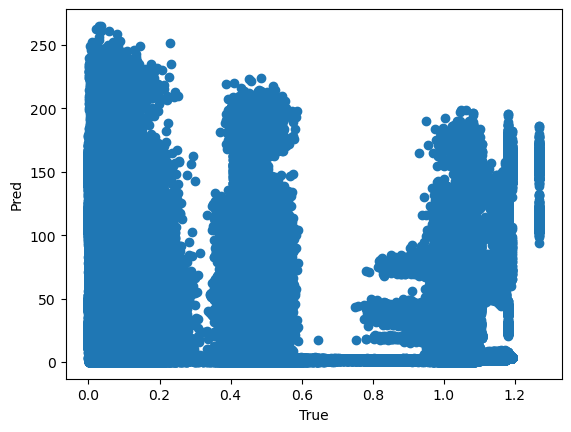

In [24]:
plt.scatter(np.abs(true.ravel()), np.abs(pred.ravel()))
plt.xlabel('True')
plt.ylabel('Pred')
#plt.savefig('../../docs/updates/figs/IC_val_scatter.png', format='png', dpi=350, bbox_inches='tight')
from sklearn.metrics import r2_score
score = r2_score(np.abs(true.ravel()), np.abs(pred.ravel()))
print(score)

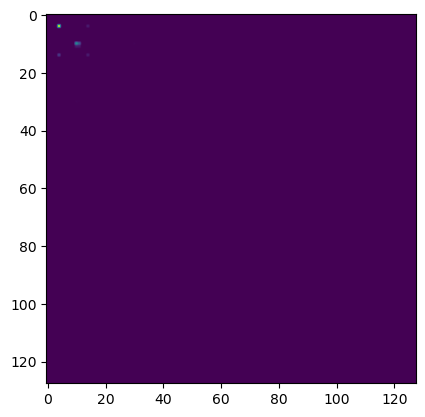

In [11]:
# get inverse of LL*
LL = pred_ic @ pred_ic.conj().T
LL_inv = np.linalg.inv(LL)
plt.imshow(np.abs(LL_inv))

LL_true = true_ic @ true_ic.conj().T
LL_inv_true = np.linalg.inv(LL_true)

LDL = pred_ic.conj().T @ DD_val @ pred_ic

In [12]:
# compare the condition numbers
cond_DD = np.linalg.cond(DD_val)
print('condition number of the original system', cond_DD)
cond_pc = np.linalg.cond(LDL)
print('condition number of the PC system', cond_pc)
cond_pc_true = np.linalg.cond(LL_inv_true @ DD_val)
print('condition number of the True PC system', cond_pc_true)

condition number of the original system 285.10274951108363
condition number of the PC system 6.8039275163962904e+16
condition number of the True PC system 52.942412885765854


In [14]:
# compute the condition number reduction throughout samples
DD_all = np.concatenate(data['inputs'], axis=0)
D_all = np.zeros((DD_all.shape[0], 128, 128), dtype=DD_all.dtype)
D_all[:, mask] = DD_all
true_ic_all = np.zeros_like(D_all)
pred_ic_all = np.zeros_like(D_all)
true_ic_all[:, mask_ic] = true
pred_ic_all[:, mask_ic] = pred

In [29]:
org_cond = []
pred_pc_cond = []
true_pc_cond = []

for i in range(D_all.shape[0]):
    org_cond.append(np.linalg.cond(D_all[i]))
    LL_i = pred_ic_all[i] @ pred_ic_all[i].conj().T
    LL_inv_i = np.linalg.inv(LL_i)
    LL_true_i = true_ic_all[i] @ true_ic_all[i].conj().T
    LL_inv_true_i = np.linalg.inv(LL_true_i)
 

    cond_pc_i = np.linalg.cond(LL_inv_i @ D_all[i])
    cond_pc_true_i = np.linalg.cond(LL_inv_true_i @ D_all[i])

    pred_pc_cond.append(cond_pc_i)
    true_pc_cond.append(cond_pc_true_i)

org_cond = np.array(org_cond)
pred_pc_cond = np.array(pred_pc_cond)
true_pc_cond = np.array(true_pc_cond)
sorted_idx = np.argsort(org_cond)

org_cond = org_cond[sorted_idx]
pred_pc_cond = pred_pc_cond[sorted_idx]
true_pc_cond = true_pc_cond[sorted_idx]
x = np.arange(org_cond.shape[0])


In [13]:
plt.scatter(x, org_cond, label='Original')
plt.scatter(x, pred_pc_cond, label='Predicted PC')
plt.scatter(x, true_pc_cond, label='True PC')
plt.xlabel('Num of samples')
plt.ylabel('Condition number')
#plt.ylim(0, 500)
plt.legend()
plt.savefig('../../docs/updates/figs/condition-num-from-KcondNum.png', format='png', dpi=350, bbox_inches='tight')

NameError: name 'x' is not defined